In [1]:
import os
from lxml import etree

import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
imfiles = []
lbfiles = []
dr = '../input/car-plate-detection/images'
drlb = '../input/car-plate-detection/annotations'
for file in os.listdir(dr):
    imfiles.append(file)
for file in os.listdir(drlb):
    lbfiles.append(file)
imfiles= sorted(imfiles)
lbfiles = sorted(lbfiles)

In [3]:
images = []
dr = '../input/car-plate-detection/images'
for file in imfiles:
    img = cv2.imread(f'{dr}/{file}')
    img = cv2.resize(img, (200,200))
    #print(f'{dr}/{file}')
    #print(np.array(img).shape)
    images.append(np.array(img))

In [4]:
def resizeannotation(f):
    tree = etree.parse(f)
    width = int(tree.xpath("size").xpath("width")[0].text)
    height = int(tree.xpath("size").xpath("height")[0].text)
    xmin = int(tree.xpath("object/bndbox").xpath("xmin")[0].text)/(width/200)
    ymin = int(tree.xpath("object/bndbox").xpath("ymin")[0].text)/(height/200)
    xmax = int(tree.xpath("object/bndbox").xpath("xmax")[0].text)/(width/200)
    ymax = int(tree.xpath("object/bndbox").xpath("ymax")[0].text)/(height/200)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [5]:
labels = []
dr = '../input/car-plate-detection/annotations'
for file in lbfiles:
    tree = etree.parse(f'{dr}/{file}')
    width = int(tree.xpath("size")[0].xpath("width")[0].text)
    height = int(tree.xpath("size")[0].xpath("height")[0].text)
    xmin = int(tree.xpath("object/bndbox")[0].xpath("xmin")[0].text)/(width/200)
    ymin = int(tree.xpath("object/bndbox")[0].xpath("ymin")[0].text)/(height/200)
    xmax = int(tree.xpath("object/bndbox")[0].xpath("xmax")[0].text)/(width/200)
    ymax = int(tree.xpath("object/bndbox")[0].xpath("ymax")[0].text)/(height/200)
    labels.append([int(xmax), int(ymax), int(xmin), int(ymin)])

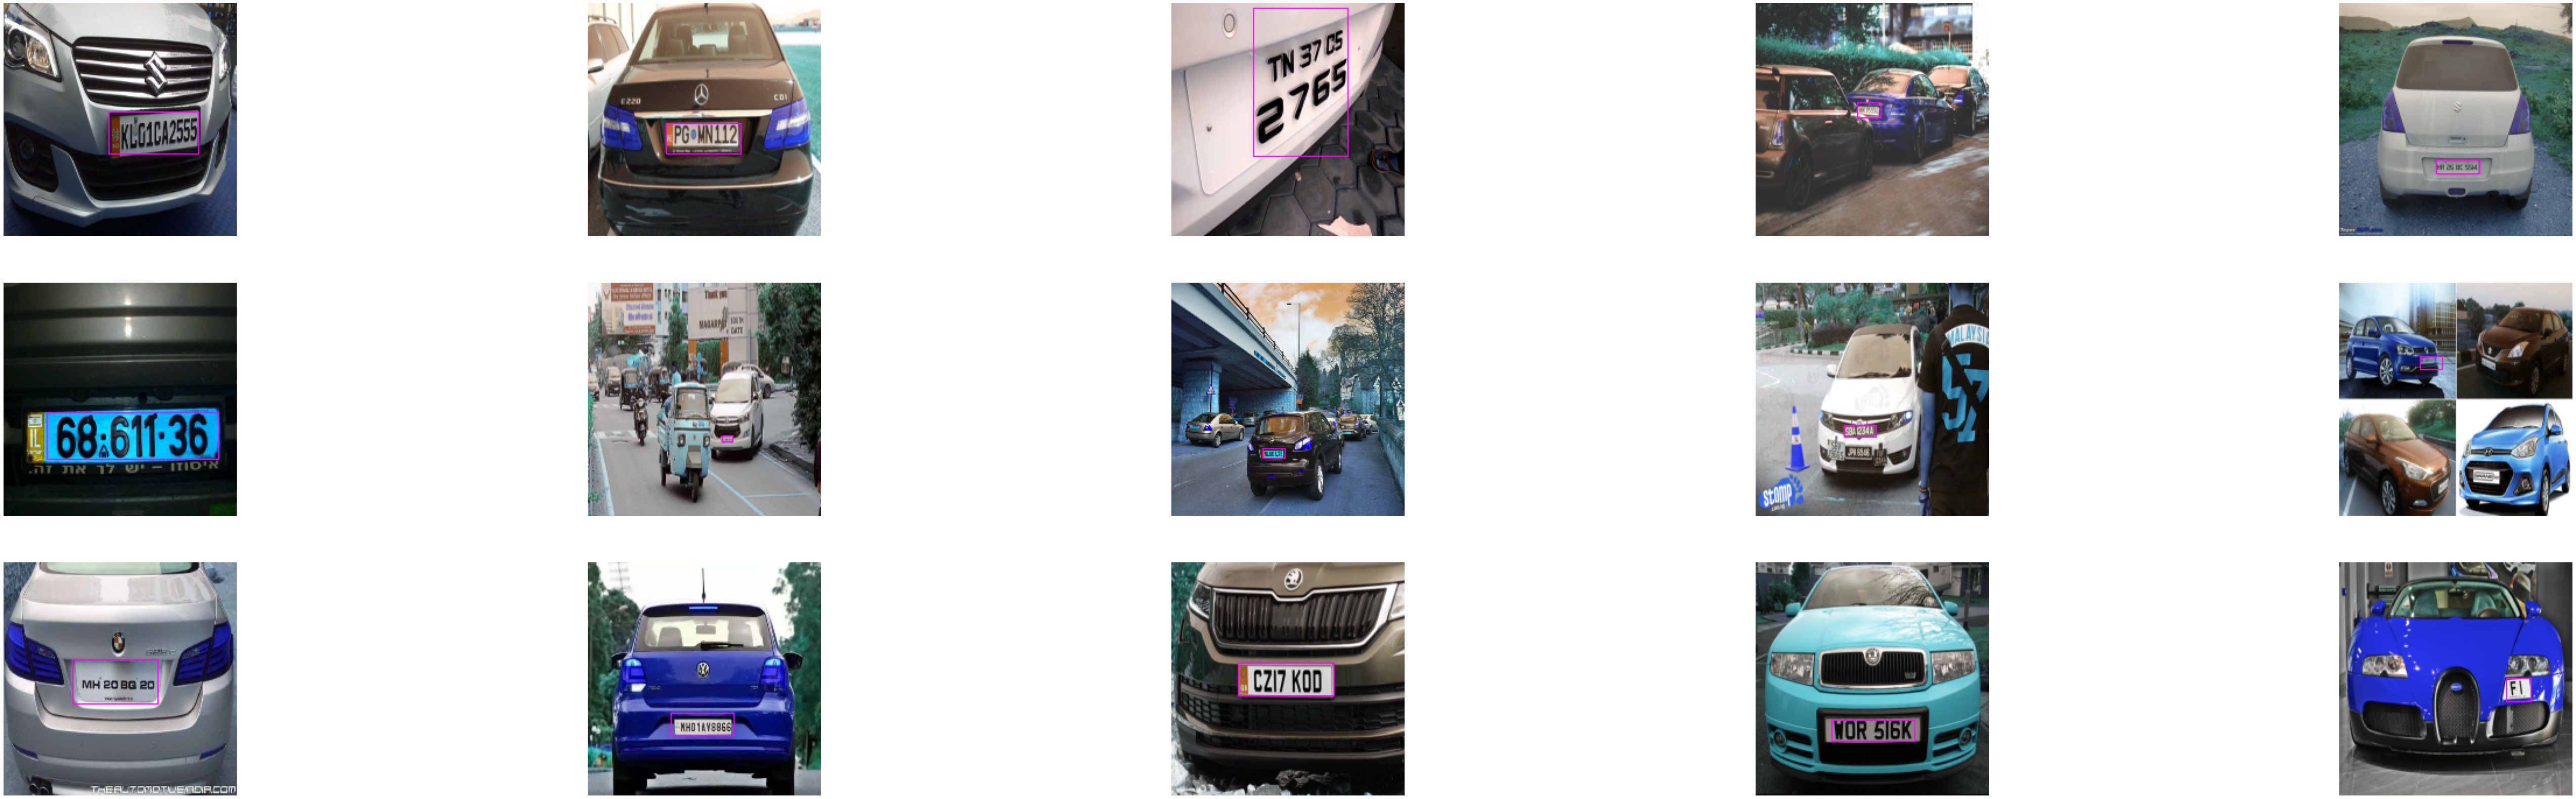

In [6]:
plt.figure(figsize = (100,100))
for i in range(15):
    image = cv2.rectangle(images[i], (labels[i][0], labels[i][1]), (labels[i][2], labels[i][3]), (255, 0, 255))
    plt.subplot(10, 5, i+1)
    plt.axis('off')
    plt.imshow(image)

In [7]:
images = np.asarray(images)
labels = np.asarray(labels)
images = images/255
labels = labels/255

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=0)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.1, random_state=0)

In [9]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16

In [10]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=images[0].shape))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2359424   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,099,140
Trainable params: 2,384,452
Non-

In [11]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [12]:
tmodel = model.fit(X_train, y_train, validation_data = (X_validation, y_validation), epochs=50, batch_size=32, verbose=1)

Epoch 1/50
10/10 [==============================] - 13s 371ms/step - loss: 0.0500 - accuracy: 0.4575 - val_loss: 0.0199 - val_accuracy: 0.4286
Epoch 2/50
10/10 [==============================] - 1s 69ms/step - loss: 0.0147 - accuracy: 0.5400 - val_loss: 0.0096 - val_accuracy: 0.4286
Epoch 3/50
10/10 [==============================] - 1s 69ms/step - loss: 0.0080 - accuracy: 0.5856 - val_loss: 0.0068 - val_accuracy: 0.6857
Epoch 4/50
10/10 [==============================] - 1s 67ms/step - loss: 0.0047 - accuracy: 0.6915 - val_loss: 0.0058 - val_accuracy: 0.7429
Epoch 5/50
10/10 [==============================] - 1s 66ms/step - loss: 0.0027 - accuracy: 0.7540 - val_loss: 0.0053 - val_accuracy: 0.8286
Epoch 6/50
10/10 [==============================] - 1s 66ms/step - loss: 0.0018 - accuracy: 0.8053 - val_loss: 0.0045 - val_accuracy: 0.8000
Epoch 7/50
10/10 [==============================] - 1s 67ms/step - loss: 0.0013 - accuracy: 0.8164 - val_loss: 0.0045 - val_accuracy: 0.8571
Epoch 8/50


In [13]:
model.save('cnn_vgg16.h5', overwrite=True) 

In [14]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 83.91%


In [15]:
y_cnn = model.predict(X_test)

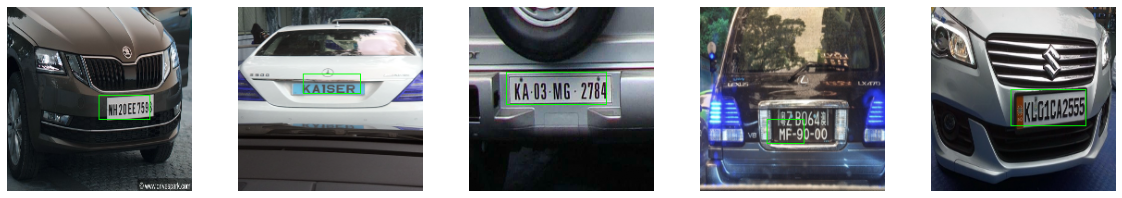

In [16]:
plt.figure(figsize=(20,40))
for i in range(45,50) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    y = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(y[0]),int(y[1])),(int(y[2]),int(y[3])),(0, 255, 0))
    plt.imshow(image)

In [17]:
img_test = cv2.imread('../input/testset3/1596025506.jpeg')
img_test = cv2.resize(img_test, (200,200))
img_test = img_test/255
img_test = np.reshape(img_test, (1,200,200,3))
y_test = model.predict(img_test)
y_test

array([[0.4660354 , 0.5160721 , 0.25488433, 0.38224545]], dtype=float32)

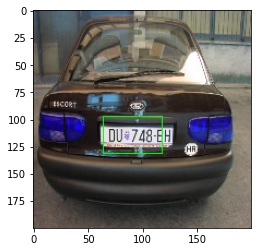

In [18]:
y_test = y_test*255
image = cv2.rectangle(img_test[0],(int(y_test[0][0]),int(y_test[0][1])),(int(y_test[0][2]),int(y_test[0][3])),(0, 255, 0))
plt.imshow(image)
plt.show()